In [1]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
import pandas as pd
import re
import numpy.ma as ma

from copy import deepcopy
from corner import corner

from chainconsumer import ChainConsumer

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

WDIR = Path().cwd().parent
DDIR = Path("/dump/lukasw/data")


In [28]:
def load_data(file):

    results = h5py.File(file, "r")
    name = str(Path(file).stem)

    try:
        __ = results['Observed']
        __ = results['Output']['Solutions']
    except KeyError:
        print(f"{file} does not have Observed or Solutions")
        results = None

    return name, results

def load_all_planet_data(path):
    path = Path(path)
    paths = Path(path).rglob("*.h5")
    paths = list(paths)

    results = [load_data(file) for file in paths]
    results = {k: v for k, v in results if v is not None}

    return results

In [29]:
pname = "HD209458b"  # "WASP-76b"  # "HD209458b"
path = Path(f"/dump/lukasw/data/OBS/{pname}/") # Path(rf"C:\Users\lukas\Documents\Git\compla\data\retrievals\{pname}")  # Path(r"C:\Users\lukas\Documents\Git\compla\data\retrievals\HD209458b")  # Path("/dump/lukasw/data/OBS/HD209458b/")
results = load_all_planet_data(path)

/dump/lukasw/data/OBS/HD209458b/G141+STIS+SPITZER/HD209458b_G141+STIS+SPITZER_freeChem.h5 does not have Observed or Solutions


In [30]:
def get_chains(results):
    chains = {}
    for name, result in results.items():
        chains[name] = {
            "trace": result['Output']['Solutions']['solution0']['tracedata'][()],
            "weights": result['Output']['Solutions']['solution0']['weights'][()],
            "parameter_names": [n[0].decode("utf-8") for n in result['Optimizer']['fit_parameter_names']],
            "solutions": result['Output']['Solutions']['solution0']['fit_params']
        }

    return chains

chains = get_chains(results)

In [5]:
print(chains.keys())
# fig = corner(
#     chains["HD209458b_G141+STIS_freeChem_fit-offset"]["trace"],
#     weights=chains["HD209458b_G141+STIS_freeChem_fit-offset"]["weights"],
#     labels=chains["HD209458b_G141+STIS_freeChem_fit-offset"]["parameter_names"]
# )
# fig.savefig("/dump/lukasw/data/OBS/HD209458b/HD209458b_G141+STIS_freeChem_fit-offset_corner.png", dpi=400)

dict_keys(['WASP-76b_STIS_freeChem', 'WASP-76b_G141_freeChem', 'WASP-76b_G141+STIS_freeChem_fit-offset', 'WASP-76b_G141+STIS_freeChem', 'WASP-76b_G141+STIS+SPITZER_freeChem', 'WASP-76b_G141+STIS+SPITZER_fit-offset_freeChem'])


In [33]:
print(chains.keys())
valid_chains = ['HD209458b_G141_freeChem', 'HD209458b_G141+STIS_freeChem', 'HD209458b_G141+STIS_freeChem_fit-offset', 'HD209458b_STIS_freeChem']
# valid_chains = ['WASP-76b_G141_freeChem', 'WASP-76b_G141+STIS_freeChem', 'WASP-76b_G141+STIS_freeChem_fit-offset', 'WASP-76b_G141+STIS+SPITZER_fit-offset_freeChem', 'WASP-76b_G141+STIS+SPITZER_freeChem', 'WASP-76b_STIS_freeChem']
print(chains[f'{pname}_G141+STIS+SPITZER_fit-offset_freeChem']["parameter_names"])

dict_keys(['HD209458b_STIS_freeChem', 'HD209458b_G141+STIS+SPITZER_fit-offset_freeChem', 'HD209458b_G141+STIS_freeChem_fit-offset', 'HD209458b_G141+STIS_freeChem', 'HD209458b_G141_freeChem'])
['planet_radius', 'T_surface', 'T_top', 'log_P_surface', 'log_P_top', 'log_P_point1', 'log_P_point2', 'T_point1', 'T_point2', 'log_H2O', 'log_CO', 'log_CO2', 'log_CH4', 'log_NH3', 'log_HCN', 'log_e-', 'log_Na', 'log_K', 'log_clouds_pressure', 'Offset_2']


In [16]:
truth_parameter_names, truths = zip(*[
    ['planet_radius',       1.38],
    # ['T_surface',           0],
    # ['T_top',               0],
    # ['log_P_surface',       0],
    ['log_P_top',           -4.50],  # Cubillos+2021
    # ['log_P_point1',        0],
    # ['log_P_point2',        0],
    # ['T_point1',            0],
    # ['T_point2',            0],
    ['log_H2O',             -5.24],  # MacDonald+2017
    ['log_CO',              -8.00],  # Cubillos+2021
    ['log_CO2',             -10.0],  # Cubillos+2021
    ['log_CH4',             -7.84],  # MacDonald+2017
    ['log_NH3',             -6.03],  # MacDonald+2017
    ['log_HCN',             -6.35],  # MacDonald+2017
    # ['log_e-',              0],
    ['log_Na',              -5.13],  # MacDonald+2017
    ['log_K',               -7.00],  # Welbanks+2019
    ['log_clouds_pressure', -4.34],  # MacDonald+2017
    # ['Offset_2',            0]
])
truth_dict = {k: v for k, v in zip(truth_parameter_names, truths)}

parameter_name, alias = zip(*[
    ['planet_radius',       r"$R_P$"],
    ['T_surface',           r"$T_{surf}$"],
    ['T_top',               r"$T_{top}$"],
    ['log_P_surface',       r"$Log [ P_{surf} ]$"],
    ['log_P_top',           r"$Log [ P_{top} ]$"],
    ['log_P_point1',        r"$Log [ P_{P1} ]$"],
    ['log_P_point2',        r"$Log [ P_{P2} ]$"],
    ['T_point1',            r"$T_{P1}$"],
    ['T_point2',            r"$T_{P2}$"],
    ['log_H2O',             r"$Log [ H_{2}O ]$"],
    ['log_CO',              r"$Log [ CO ]$"],
    ['log_CO2',             r"$Log [ CO_{2} ]$"],
    ['log_CH4',             r"$Log [ CH_{4} ]$"],
    ['log_NH3',             r"$Log [ NH_{3} ]$"],
    ['log_HCN',             r"$Log [ HCN ]$"],
    ['log_e-',              r"$Log [ e^{-} ]$"],
    ['log_Na',              r"$Log [ Na ]$"],
    ['log_K',               r"$Log [ K ]$"],
    ['log_clouds_pressure', r"$Log [ P_{clouds} ]$"],
    ['Offset_2',            r"$\Delta_{STIS}$"],
])
alias_dict = {k: v for k, v in zip(parameter_name, alias)}

def get_case_from_name(s):
    ls = s.split("_")
    instr = ls[1]
    chem = "NONE"
    fit_offset = ""
    if len(ls) == 3:
        chem = ls[2]
    elif len(ls) == 4:
        chem = ls[2]
        fit_offset = ls[3]
    else:
        raise NotImplementedError

    return instr, chem, fit_offset

def style_picker(instr, chem, fit_offset):
    if chem == "freeChem":
        ls = "solid"
    else:
        ls = "dashed"

    if instr == "G141":
        pass
    elif instr == "STIS":
        pass

print([alias_dict[p] for p in ['planet_radius', 'T_surface', 'T_top', 'log_P_surface', 'log_P_top', 'log_P_point1', 'log_P_point2', 'T_point1', 'T_point2', 'log_H2O', 'log_CO', 'log_CO2', 'log_CH4', 'log_NH3', 'log_HCN', 'log_e-', 'log_Na', 'log_K', 'log_clouds_pressure', 'Offset_2']])

['$R_P$', '$T_{surf}$', '$T_{top}$', '$Log [ P_{surf} ]$', '$Log [ P_{top} ]$', '$Log [ P_{P1} ]$', '$Log [ P_{P2} ]$', '$T_{P1}$', '$T_{P2}$', '$Log [ H_{2}O ]$', '$Log [ CO ]$', '$Log [ CO_{2} ]$', '$Log [ CH_{4} ]$', '$Log [ NH_{3} ]$', '$Log [ HCN ]$', '$Log [ e^{-} ]$', '$Log [ Na ]$', '$Log [ K ]$', '$Log [ P_{clouds} ]$', '$\\Delta_{STIS}$']


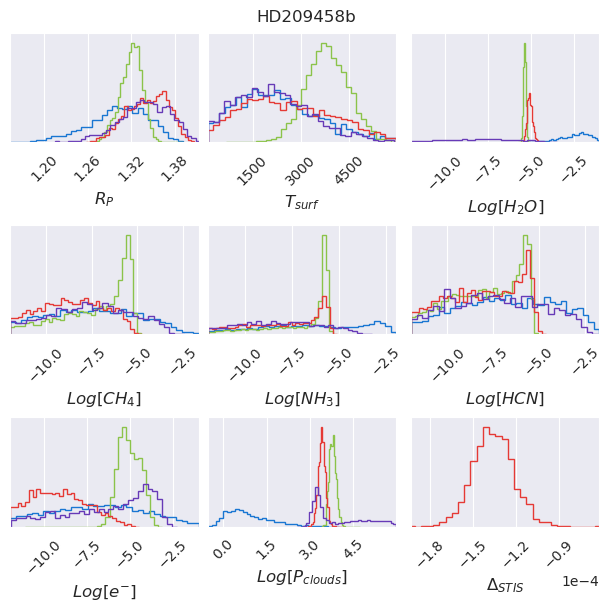

In [38]:
valid_chains = ['HD209458b_G141_freeChem', 'HD209458b_G141+STIS_freeChem', 'HD209458b_G141+STIS_freeChem_fit-offset', 'HD209458b_STIS_freeChem']
# valid_chains = ['WASP-76b_G141_freeChem', 'WASP-76b_G141+STIS_freeChem', 'WASP-76b_G141+STIS_freeChem_fit-offset', 'WASP-76b_STIS_freeChem'] #, 'WASP-76b_G141+STIS+SPITZER_freeChem', 'WASP-76b_G141+STIS+SPITZER_fit-offset_freeChem',]

def plot_all_chains(chains, which_chains, planet_name, kde=False):
    c = ChainConsumer()
    for name in which_chains:
        instr, chem, fit_offset = get_case_from_name(name)

        chain = chains[name]
        parameters = [alias_dict[k] for k in chain["parameter_names"]]
        c.add_chain(
            chain["trace"],
            weights=chain["weights"],
            parameters=parameters,
            name=name.replace(f'{planet_name}_', ""),
            plot_point=True,
        )

    # truth_labels = [alias_dict[k] for k in truth_parameter_names]
    # c.add_marker(
    #     truths,
    #     parameters=truth_labels,
    #     name="Lit., several authors",
    #     color="black",
    #
    # )

    c.configure(
        statistics="max",
        sigma2d=True,
        sigmas=[0, 1],
        kde=kde, # defaults to False
        smooth=False,
        shade=True,
        shade_alpha=0.1,
        shade_gradient=0.3,
        bar_shade=False,
        plot_contour=True,
        usetex=False,
    )

    c.configure_truth(ls="dashed", color="gray")

    # fig_sum = c.plotter.plot_summary(
    #     truth=truth_dict,
    #     display=False,
    # )
    # fig_sum.savefig(r"C:\Users\lukas\Documents\Git\compla\data\retrievals\HD209458b\full_summary.png", dpi=200)

    # print(c.analysis.get_correlation_table(chain=2, caption='Parameter Correlations (HD209458b: G141+STIS with freeChem and offset fitting)'))
    # print("\n\n")
    # print(c.analysis.get_covariance_table(chain=2, caption='Parameter Covariance (HD209458b: G141+STIS with freeChem and offset fitting)'))
    # print("\n\n")
    # print(c.analysis.get_latex_table(caption='Summary: HD209458b'))
    # print("\n\n")
    # print(c.comparison.comparison_table(caption='Comparison: HD209458b'))

    which_parameters = [alias_dict[p] for p in ['planet_radius', 'T_surface', 'log_H2O', 'log_CH4', 'log_NH3', 'log_HCN', 'log_e-', 'log_clouds_pressure', 'Offset_2']
                        # ['planet_radius', 'T_surface', 'log_H2O', 'log_e-', 'log_clouds_pressure', 'Offset_2']
                        ]

    fig = c.plotter.plot_distributions(
        # truth=truth_dict,
        display=False,
        col_wrap=3,
        parameters=which_parameters,
    )
    fig.suptitle(planet_name)
    fig.set_layout_engine(layout="constrained")
    fig.savefig(f"/dump/lukasw/data/OBS/{planet_name}/small_1d_distributions.png", dpi=400)

    # fig = c.plotter.plot(
    #     truth=truth_dict,
    #     display=False,
    #     parameters=which_parameters,
    # )
    # fig.suptitle(planet_name)
    # # fig.set_layout_engine(layout="constrained")
    # fig.savefig(f"/dump/lukasw/data/OBS/{planet_name}/small_corner_high_res.png", dpi=400)

plot_all_chains(chains, valid_chains, planet_name=pname)